# 資優生策略

In [2]:
import pandas as pd

def toSeasonal(df):
    season4 = df[df.index.month == 3]
    season1 = df[df.index.month == 5]
    season2 = df[df.index.month == 8]
    season3 = df[df.index.month == 11]

    season1.index = season1.index.year
    season2.index = season2.index.year
    season3.index = season3.index.year
    season4.index = season4.index.year - 1

    newseason1 = season1
    newseason2 = season2 - season1.reindex_like(season2)
    newseason3 = season3 - season2.reindex_like(season3)
    newseason4 = season4 - season3.reindex_like(season4)

    newseason1.index = pd.to_datetime(newseason1.index.astype(str) + '-05-15')
    newseason2.index = pd.to_datetime(newseason2.index.astype(str) + '-08-14')
    newseason3.index = pd.to_datetime(newseason3.index.astype(str) + '-11-14')
    newseason4.index = pd.to_datetime((newseason4.index + 1).astype(str) + '-03-31')

    return newseason1.append(newseason2).append(newseason3).append(newseason4).sort_index()

def mystrategy2(data):
    
    股本 = data.get('股本合計', 1)#.drop_duplicates(['stock_id', 'date'], keep='last')#.pivot(index='date', columns='stock_id')
    price = data.get('收盤價', 200)
    當天股價 = price[:股本.index[-1]].iloc[-1]
    當天股本 = 股本.iloc[-1]
    市值 = 當天股本 * 當天股價 / 10 * 1000
   

    df1 = toSeasonal(data.get('投資活動之淨現金流入（流出）', 5))
    df2 = toSeasonal(data.get('營業活動之淨現金流入（流出）', 5))
    自由現金流 = (df1 + df2).iloc[-4:].mean()
    
    
    稅後淨利 = data.get('本期淨利（淨損）', 1)
    
    # 股東權益，有兩個名稱，有些公司叫做權益總計，有些叫做權益總額
    # 所以得把它們抓出來
    權益總計 = data.get('權益總計', 1)
    權益總額 = data.get('權益總額', 1)
    
    # 並且把它們合併起來
    權益總計.fillna(權益總額, inplace=True)
        
    股東權益報酬率 = 稅後淨利.iloc[-1] / 權益總計.iloc[-1]
    
    
    營業利益 = data.get('營業利益（損失）', 5)
    營業利益成長率 = (營業利益.iloc[-1] / 營業利益.iloc[-5] - 1) * 100
    
    
    當月營收 = data.get('當月營收', 4) * 1000
    當季營收 = 當月營收.iloc[-4:].sum()
    市值營收比 = 市值 / 當季營收
    
    rsv = (price.iloc[-1] - price.iloc[-150:].min()) / (price.iloc[-150:].max() - price.iloc[-150:].min())
    
    
    condition1 = (市值 < 1e10)
    condition2 = 自由現金流 > 0
    condition3 = 股東權益報酬率 > 0
    condition4 = 營業利益成長率 > 0
    condition5 = 市值營收比 < 5
    condition6 = rsv > 0.5
    
    select_stock = condition1 & condition2 & condition3 & condition4 & condition5 & condition6
    
    return select_stock[select_stock]


In [4]:
from strategies.new_strategy import strategy
from finlab.data import Data
data = Data()
strategy(data)

/Users/leonko/Desktop/finlab_course/finlab/data.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = (pd.read_sql(s1, self.conn)
/Users/leonko/Desktop/finlab_course/finlab/data.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = (pd.read_sql(s1, self.conn)
/Users/leonko/Desktop/finlab_course/strategies/new_strategy.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return newseason1.append(newseason2).append(newseason3).append(newseason4).sort_index()
/Users/leonko/Desktop/finlab_course/strategies/new_strategy.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return newseason1.append(newseason2).append(newseason3).append

stock_id
1528    True
1720    True
1752    True
1810    True
1817    True
2321    True
2349    True
2423    True
2425    True
2467    True
2468    True
2472    True
2480    True
2482    True
2493    True
2496    True
2543    True
2753    True
3038    True
3048    True
3051    True
4439    True
4545    True
4552    True
4557    True
4763    True
4960    True
5225    True
5258    True
5283    True
5284    True
6112    True
6128    True
6139    True
6197    True
8070    True
8103    True
8473    True
9924    True
dtype: bool

# 檢查報酬率

2018-03-01 - 2018-04-30 報酬率: 0.96 % nstock 37
每次換手最大報酬 : 0.96 ％
每次換手最少報酬 : 0.96 ％


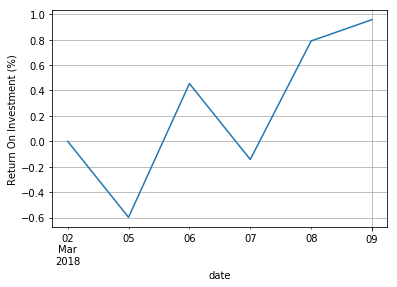

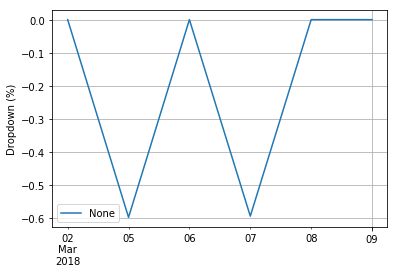

2018-03-02    1.000000
2018-03-05    0.994015
2018-03-06    1.004545
2018-03-07    0.998569
2018-03-08    1.007899
2018-03-09    1.009578
dtype: float64

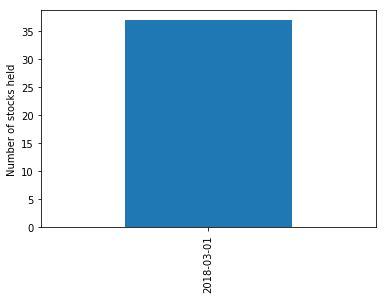

In [49]:
# 起手式
from finlab.backtest import backtest
from finlab.data import Data
import datetime
%matplotlib inline

# 回測
data = Data()
backtest(datetime.date(2018,3,1), datetime.date(2018,3,10), 60, mystrategy2, data)

# 更新持股投資張數

In [50]:
from finlab.backtest import portfolio

data = Data()

# 利用 mystrategy2 來產生股票清單 stocks
stocks = mystrategy2(data)

# 用portfolio來幫忙計算，給定 1000000 元，依照今天收盤價，股票張數要如何分配
p, total_invest_money = portfolio(stocks.index, 1000000, data)

# 印出股票資訊
print('---------------')
print('|  portfolio  |')
print('---------------')
print(p)
print('total cost')
print(total_invest_money)

estimate price according to 2018-05-28 00:00:00
initial number of stock 23
after considering fee 23
after considering 1000 share 19
---------------
|  portfolio  |
---------------
stock_id
1231    1.0
1309    3.0
1533    1.0
1701    2.0
1712    3.0
1727    3.0
1730    1.0
2028    4.0
2365    4.0
2414    2.0
2430    2.0
2480    1.0
2546    2.0
2601    4.0
3029    2.0
3056    2.0
4916    1.0
5515    4.0
6112    1.0
Name: 2018-05-28 00:00:00, dtype: float64
total cost
855900.0
